# How to use ColPali with Weaviate's Named Vectors!

ColPali uses a multi-vector embedding search method similar to ColBERT, embedding an image into 1024 patch vectors.

This notebook will show you how to embed images with ColPali, how to import patch vectors into Weaviate using Named Vectors, and how to query with Weaviate's Named Vectors!

Note: This is a workaround solution that does not yet implement the MaxSim operator.

We will test this with 3 PDFs:
- NBA_voting.pdf
- Boston_restaurants.pdf
- DSPy.pdf

# ColPali Setup

In [1]:
!pip install pdf2image==1.17.0 > /dev/null
!pip install peft==0.12.0 > /dev/null

In [2]:
!sudo apt-get update > /dev/null
!sudo apt-get install poppler-utils > /dev/null

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [45]:
import os
import numpy as np
from pathlib import Path
from typing import List, cast
from pdf2image import convert_from_path
from PIL import Image
import torch
from torch import nn
from transformers import LlamaTokenizerFast, PaliGemmaProcessor
from transformers.models.paligemma.configuration_paligemma import PaliGemmaConfig
from transformers.models.paligemma.modeling_paligemma import PaliGemmaForConditionalGeneration, PaliGemmaPreTrainedModel

# Define ColPali model
class ColPali(PaliGemmaPreTrainedModel):
    def __init__(self, config: PaliGemmaConfig):
        super(ColPali, self).__init__(config=config)
        self.model = PaliGemmaForConditionalGeneration(config)
        self.dim = 128
        self.custom_text_proj = nn.Linear(self.model.config.text_config.hidden_size, self.dim)
        self.main_input_name = "doc_input_ids"

    def forward(self, *args, **kwargs) -> torch.Tensor:
        outputs = self.model(*args, output_hidden_states=True, **kwargs)
        last_hidden_states = outputs.hidden_states[-1]
        proj = self.custom_text_proj(last_hidden_states)
        proj = proj / proj.norm(dim=-1, keepdim=True)
        '''
        The attention_mask will zero out embeddings for any padding tokens or patches.
        More concretely, the `proj` tensor currently has shape [batch_size, sequence_length, self.dim]
        The `.unsqueeze` transformation will result in the attention mask having the shape [batch_size, sequence_length, 1]
        '''
        proj = proj * kwargs["attention_mask"].unsqueeze(-1)
        return proj

# Define input classes
class ColPaliTextInput:
    def __init__(self, input_ids, attention_mask):
        self.input_ids = input_ids
        self.attention_mask = attention_mask

    def to(self, device):
        return ColPaliTextInput(
            input_ids=self.input_ids.to(device),
            attention_mask=self.attention_mask.to(device),
        )

class ColPaliImageInput:
    def __init__(self, input_ids, pixel_values, attention_mask):
        self.input_ids = input_ids
        self.pixel_values = pixel_values
        self.attention_mask = attention_mask

    def to(self, device):
        return ColPaliImageInput(
            input_ids=self.input_ids.to(device),
            pixel_values=self.pixel_values.to(device),
            attention_mask=self.attention_mask.to(device),
        )

# Define ColPaliProcessor
class ColPaliProcessor:
    def __init__(self, processor: PaliGemmaProcessor):
        self.processor = processor
        self.tokenizer = cast(LlamaTokenizerFast, self.processor.tokenizer)

    @staticmethod
    def from_pretrained(model_name: str) -> 'ColPaliProcessor':
        return ColPaliProcessor(processor=PaliGemmaProcessor.from_pretrained(model_name))

    def process_text(self, text: str | List[str], padding: str = "longest", return_tensors: str = "pt", add_special_tokens: bool = True) -> ColPaliTextInput:
        if add_special_tokens:
            if isinstance(text, str):
                text = self.tokenizer.bos_token + text + "\n"
            elif isinstance(text, list):
                text = [self.tokenizer.bos_token + t + "\n" for t in text]
            else:
                raise ValueError("text must be a string or a list of strings.")

        batch_output = self.tokenizer(text, padding=padding, return_tensors=return_tensors, add_special_tokens=add_special_tokens)

        return ColPaliTextInput(
            input_ids=batch_output["input_ids"],
            attention_mask=batch_output["attention_mask"],
        )

    def process_image(self, image: Image.Image | List[Image.Image], padding: str = "longest", do_convert_rgb: bool = True, return_tensors: str = "pt", add_special_prompt: bool = True) -> ColPaliImageInput:
        special_prompt = "Describe the image." if add_special_prompt else None
        if isinstance(image, Image.Image):
            text_input = [special_prompt]
        elif isinstance(image, list):
            text_input = [special_prompt] * len(image)
        else:
            raise ValueError("image must be a PIL Image or a list of PIL Images.")

        batch_output = self.processor(
            text=text_input,
            images=image,
            padding=padding,
            do_convert_rgb=do_convert_rgb,
            return_tensors=return_tensors,
        )

        return ColPaliImageInput(
            input_ids=batch_output["input_ids"],
            pixel_values=batch_output["pixel_values"],
            attention_mask=batch_output["attention_mask"],
        )

    def decode(self, *args, **kwargs):
        return self.tokenizer.decode(*args, **kwargs)

    def batch_decode(self, *args, **kwargs):
        return self.tokenizer.batch_decode(*args, **kwargs)

# Helper functions
def convert_pdf_to_images(pdf_file: str, save_folder: str) -> List[Image.Image]:
    images = convert_from_path(pdf_file)
    os.makedirs(save_folder, exist_ok=True)
    saved_images = []
    for i, image in enumerate(images):
        image_path = os.path.join(save_folder, f"{pdf_file}_page_{i+1}.jpg")
        image.save(image_path, "JPEG")
        saved_images.append(Image.open(image_path))
    return saved_images

def process_pdfs_with_colpali(pdf_files, output_dir, model, processor):
    all_embeddings = []
    all_page_info = []

    for pdf_file in pdf_files:
        pdf_images = convert_pdf_to_images(pdf_file, os.path.join(output_dir, "pdf_images"))

        for page_num, image in enumerate(pdf_images):
            image_input = processor.process_image(image).to(model.device)
            with torch.no_grad():
                page_embedding = model(**vars(image_input))

            all_embeddings.append(page_embedding.cpu().numpy().squeeze()) # the last .squeeze() call removes the batch dimension
            all_page_info.append({"pdf": pdf_file, "page": page_num})

    embeddings_array = np.array(all_embeddings)

    np.save(Path(output_dir) / "embeddings.npy", embeddings_array)
    np.save(Path(output_dir) / "page_info.npy", all_page_info)

    return embeddings_array, all_page_info

def answer_query_with_colpali(query, embeddings_array, page_info, model, processor):
    query_input = processor.process_text(query).to(model.device)
    with torch.no_grad():
        query_embedding = model(**vars(query_input))

    # Reshape embeddings if necessary
    if len(embeddings_array.shape) == 3:
        embeddings_array = embeddings_array.mean(axis=1)  # Average over sequence dimension
    if len(query_embedding.shape) == 3:
        query_embedding = query_embedding.mean(axis=1)  # Average over sequence dimension

    # Ensure both embeddings are 2D
    embeddings_array = embeddings_array.squeeze()
    query_embedding = query_embedding.cpu().numpy().squeeze() # remove batch_dimension with the last squeeze call

    # Compute similarity scores
    similarity_scores = np.dot(embeddings_array, query_embedding.T)

    K = 5
    top_k_indices = np.argsort(similarity_scores.flatten())[-K:][::-1]

    top_results = [
        {"score": similarity_scores.flatten()[i], "info": page_info[i]}
        for i in top_k_indices
    ]

    return top_results

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_path = "google/paligemma-3b-mix-448" # can also try smaller models
lora_path = "vidore/colpali"

model = ColPali.from_pretrained(model_path) # torch_dtype = torch.bfloat16 # there is also a `bitsandbytes` setup for 8-bit / 4-bit
model.load_adapter(lora_path, adapter_name="colpali")
model.to(device);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of ColPali were not initialized from the model checkpoint at google/paligemma-3b-mix-448 and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight', 'language_model.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

In [7]:
processor = ColPaliProcessor.from_pretrained(model_path)

pdf_files = ["2022_Annual_Financial_Report.pdf", "2023-24-Kia-NBA-MVP-Voting-Results.pdf", "2410.12896v1.pdf"]
output_dir = "colpali_output"

# Process PDFs and save embeddings
embeddings, page_info = process_pdfs_with_colpali(pdf_files, output_dir, model, processor)

# Answer a query
query = "How much are expenses for 2022?" # The answer should be contained in Boston-Restaurants.pdf
results = answer_query_with_colpali(query, embeddings, page_info, model, processor)

# Print results
for result in results:
  print(f"Score: {result['score']}, PDF: {result['info']['pdf']}, Page: {result['info']['page']}")

Score: 0.4149171710014343, PDF: 2022_Annual_Financial_Report.pdf, Page: 12
Score: 0.38959625363349915, PDF: 2022_Annual_Financial_Report.pdf, Page: 32
Score: 0.3700498938560486, PDF: 2022_Annual_Financial_Report.pdf, Page: 58
Score: 0.3633248209953308, PDF: 2022_Annual_Financial_Report.pdf, Page: 16
Score: 0.36185380816459656, PDF: 2022_Annual_Financial_Report.pdf, Page: 11


In [8]:
query = "How many votes did Jayson Tatum get for MVP?" # The answer should be contained in NBA-mvp-voting.pdf
results = answer_query_with_colpali(query, embeddings, page_info, model, processor)

# Print results
for result in results:
  print(f"Score: {result['score']}, PDF: {result['info']['pdf']}, Page: {result['info']['page']}")

Score: 0.3397757411003113, PDF: 2023-24-Kia-NBA-MVP-Voting-Results.pdf, Page: 0
Score: 0.2617005705833435, PDF: 2022_Annual_Financial_Report.pdf, Page: 22
Score: 0.25475969910621643, PDF: 2022_Annual_Financial_Report.pdf, Page: 9
Score: 0.2534480094909668, PDF: 2022_Annual_Financial_Report.pdf, Page: 13
Score: 0.2528792917728424, PDF: 2022_Annual_Financial_Report.pdf, Page: 11


In [9]:
query = "What is an LLM programming language?" # The answer should be contained in DSPy.pdf
results = answer_query_with_colpali(query, embeddings, page_info, model, processor)

# Print results
for result in results:
  print(f"Score: {result['score']}, PDF: {result['info']['pdf']}, Page: {result['info']['page']}")

Score: 0.3158888518810272, PDF: 2410.12896v1.pdf, Page: 17
Score: 0.2923925220966339, PDF: 2410.12896v1.pdf, Page: 16
Score: 0.2891688942909241, PDF: 2410.12896v1.pdf, Page: 15
Score: 0.28432899713516235, PDF: 2410.12896v1.pdf, Page: 7
Score: 0.2792513072490692, PDF: 2410.12896v1.pdf, Page: 11


In [10]:
sample_image = Image.open("./colpali_output/pdf_images/page_1.jpg")  # Get the first page of the first PDF
image_input = processor.process_image(sample_image).to(model.device)
with torch.no_grad():
    sample_output = model(**vars(image_input))

# The shape of sample_output should be [batch_size, num_patches, embedding_dim]
num_patches = sample_output.shape[1]

print(f"Number of patches per image: {num_patches}")
# 1030 ==> 1024 image patches + 5 special tokens (described in original ColBERT paper + 1[CLS] token)

Number of patches per image: 1030


# Weaviate Setup

In [11]:
!pip install weaviate-client==4.7.1 > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.28.3 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.28.3 which is incompatible.
tensorboard 2.17.0 requires protobuf!=4.24.0,<5.0.0,>=3.19.6, but you have protobuf 5.28.3 which is incompatible.
tensorflow 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.28.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 5.28.3 which is incompatible.


In [34]:
import weaviate
import os

client = weaviate.connect_to_embedded(
    version="1.26.1"
)

INFO:weaviate-client:Started /root/.cache/weaviate-embedded: process ID 16907


In [47]:
import weaviate.classes as wvc

patch_vector_properties = [
    wvc.config.Property(name=f"patch_{idx}", data_type=wvc.config.DataType.TEXT) for idx in range(num_patches)
]

patch_vector_names = [f"patch_{idx}" for idx in range(num_patches)] # used for querying

patch_vectorizer_config = [
    wvc.config.Configure.NamedVectors.none(
        name=f"patch_{idx}"
    ) for idx in range(num_patches)
]
client.collections.delete_all()

paper_pdfs = client.collections.create(
    name="PaperPDFs",
    description="Scientific paper PDFs",
    vectorizer_config=patch_vectorizer_config,
    properties=patch_vector_properties
)

In [50]:
def import_pdfs_with_colpali_to_weaviate(weaviate_collection, pdf_files, model, processor):
    device = next(model.parameters()).device  # Get the device of the model

    for pdf_file in pdf_files:
        pdf_images = convert_pdf_to_images(pdf_file, "pdf_images_temp")

        for page_num, image in enumerate(pdf_images):
            # Process the image
            image_input = processor.process_image(image)
            # Move the processed input to the correct device
            image_input = ColPaliImageInput(
                input_ids=image_input.input_ids.to(device),
                pixel_values=image_input.pixel_values.to(device),
                attention_mask=image_input.attention_mask.to(device)
            )

            with torch.no_grad():
                patch_embeddings = model(**vars(image_input))

            # Create a dictionary for the Weaviate object
            properties = {
                "fileName": pdf_file,
                "pageNumber": page_num,
                "image_path": image.filename
            }
            vector = {}

            # Add each patch embedding to the data object
            for idx, patch_embedding in enumerate(patch_embeddings[0]):
                properties[f"patch_{idx}"] = ""
                vector[f"patch_{idx}"] = patch_embedding.cpu().numpy().tolist()

            # Add to Weaviate
            paper_pdfs.data.insert(properties=properties, vector=vector)

    print(f"Processed {len(pdf_files)} PDF files.")

In [51]:
import_pdfs_with_colpali_to_weaviate(paper_pdfs, pdf_files, model, processor)

Processed 3 PDF files.


In [40]:
def embed_query_with_colpali(query, model, processor):
    query_input = processor.process_text(query).to(model.device)
    with torch.no_grad():
        query_embedding = model(**vars(query_input))

    # Print shape for debugging
    print(f"Query embedding shape: {query_embedding.shape}")

    query_vectors = {}
    num_tokens = query_embedding.shape[1]
    for idx in range(num_patches):
        # Use modulo to cycle through token embeddings if num_tokens < num_patches
        token_idx = idx % num_tokens
        query_vectors[f"patch_{idx}"] = query_embedding[0, token_idx].cpu().numpy().tolist()

    return query_vectors

In [41]:
query_vectors = embed_query_with_colpali("How much are expenses for 2022?", model, processor)

Query embedding shape: torch.Size([1, 13, 128])


fileName: 2022_Annual_Financial_Report.pdf
pageNumber: 12.0
image_path: /content/pdf_images_temp/2022_Annual_Financial_Report.pdf_page_13.jpg
Filename: 2022_Annual_Financial_Report.pdf on page 12.0.


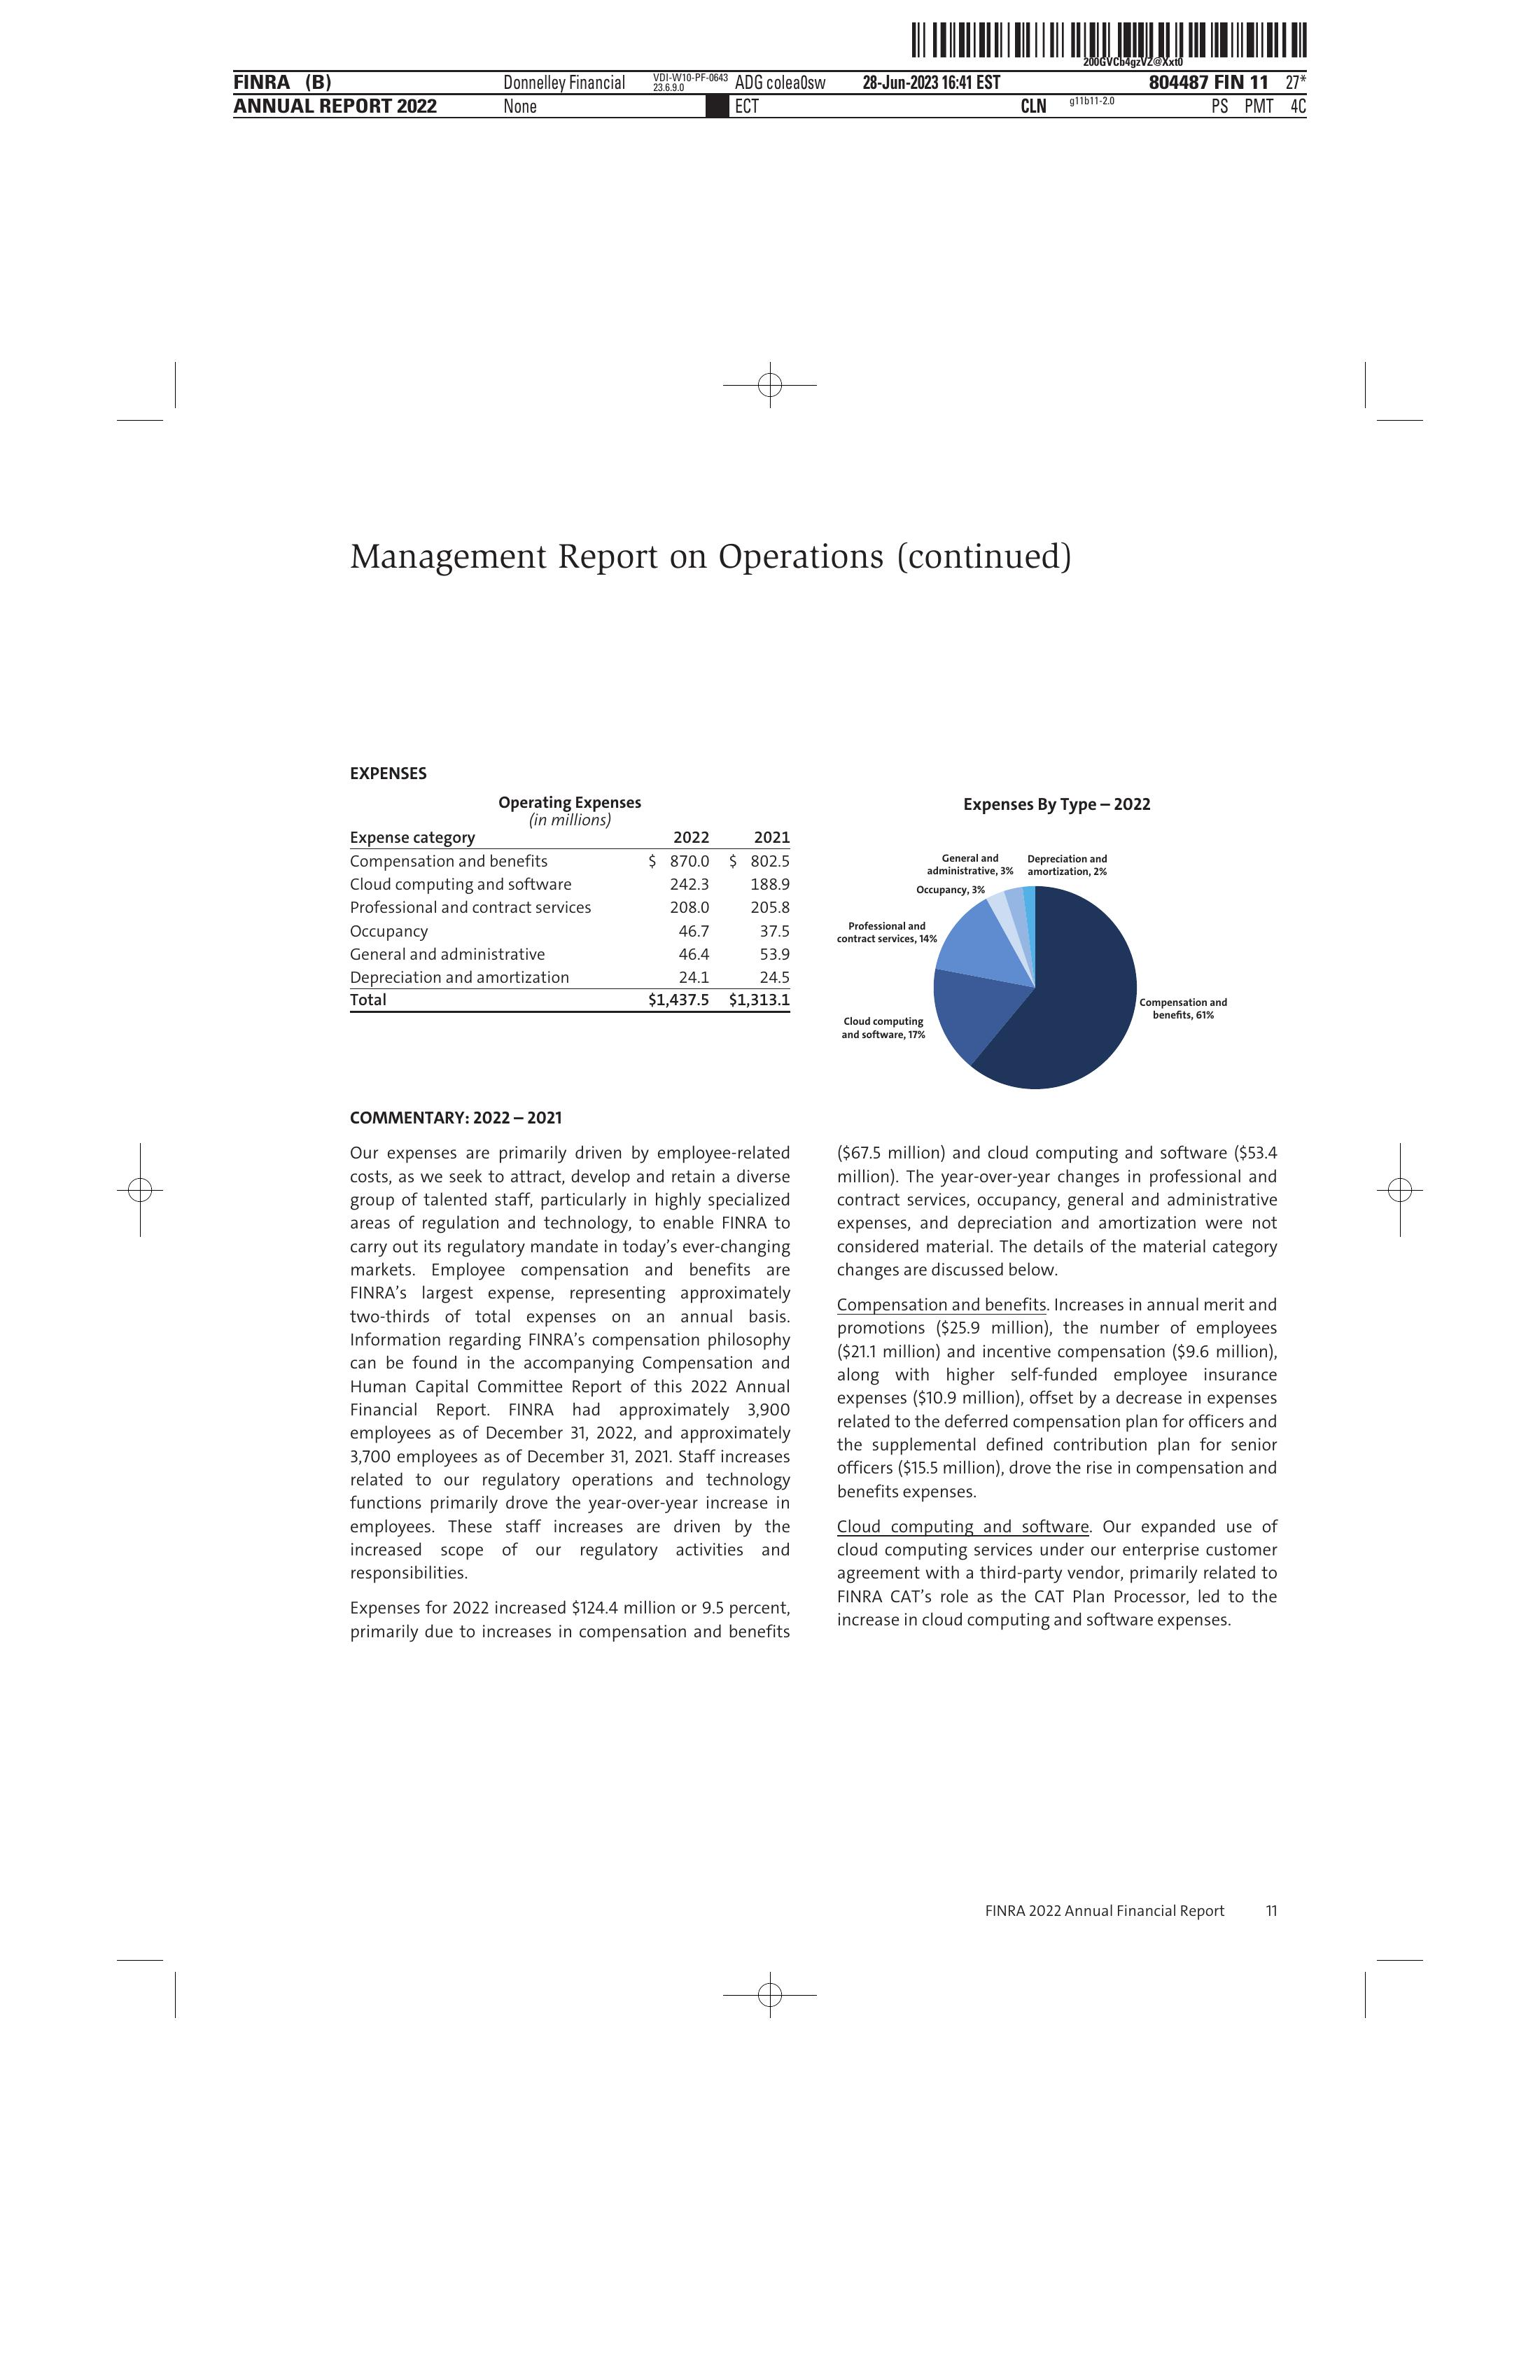

pageNumber: 40.0
image_path: /content/pdf_images_temp/2022_Annual_Financial_Report.pdf_page_41.jpg
fileName: 2022_Annual_Financial_Report.pdf
Filename: 2022_Annual_Financial_Report.pdf on page 40.0.


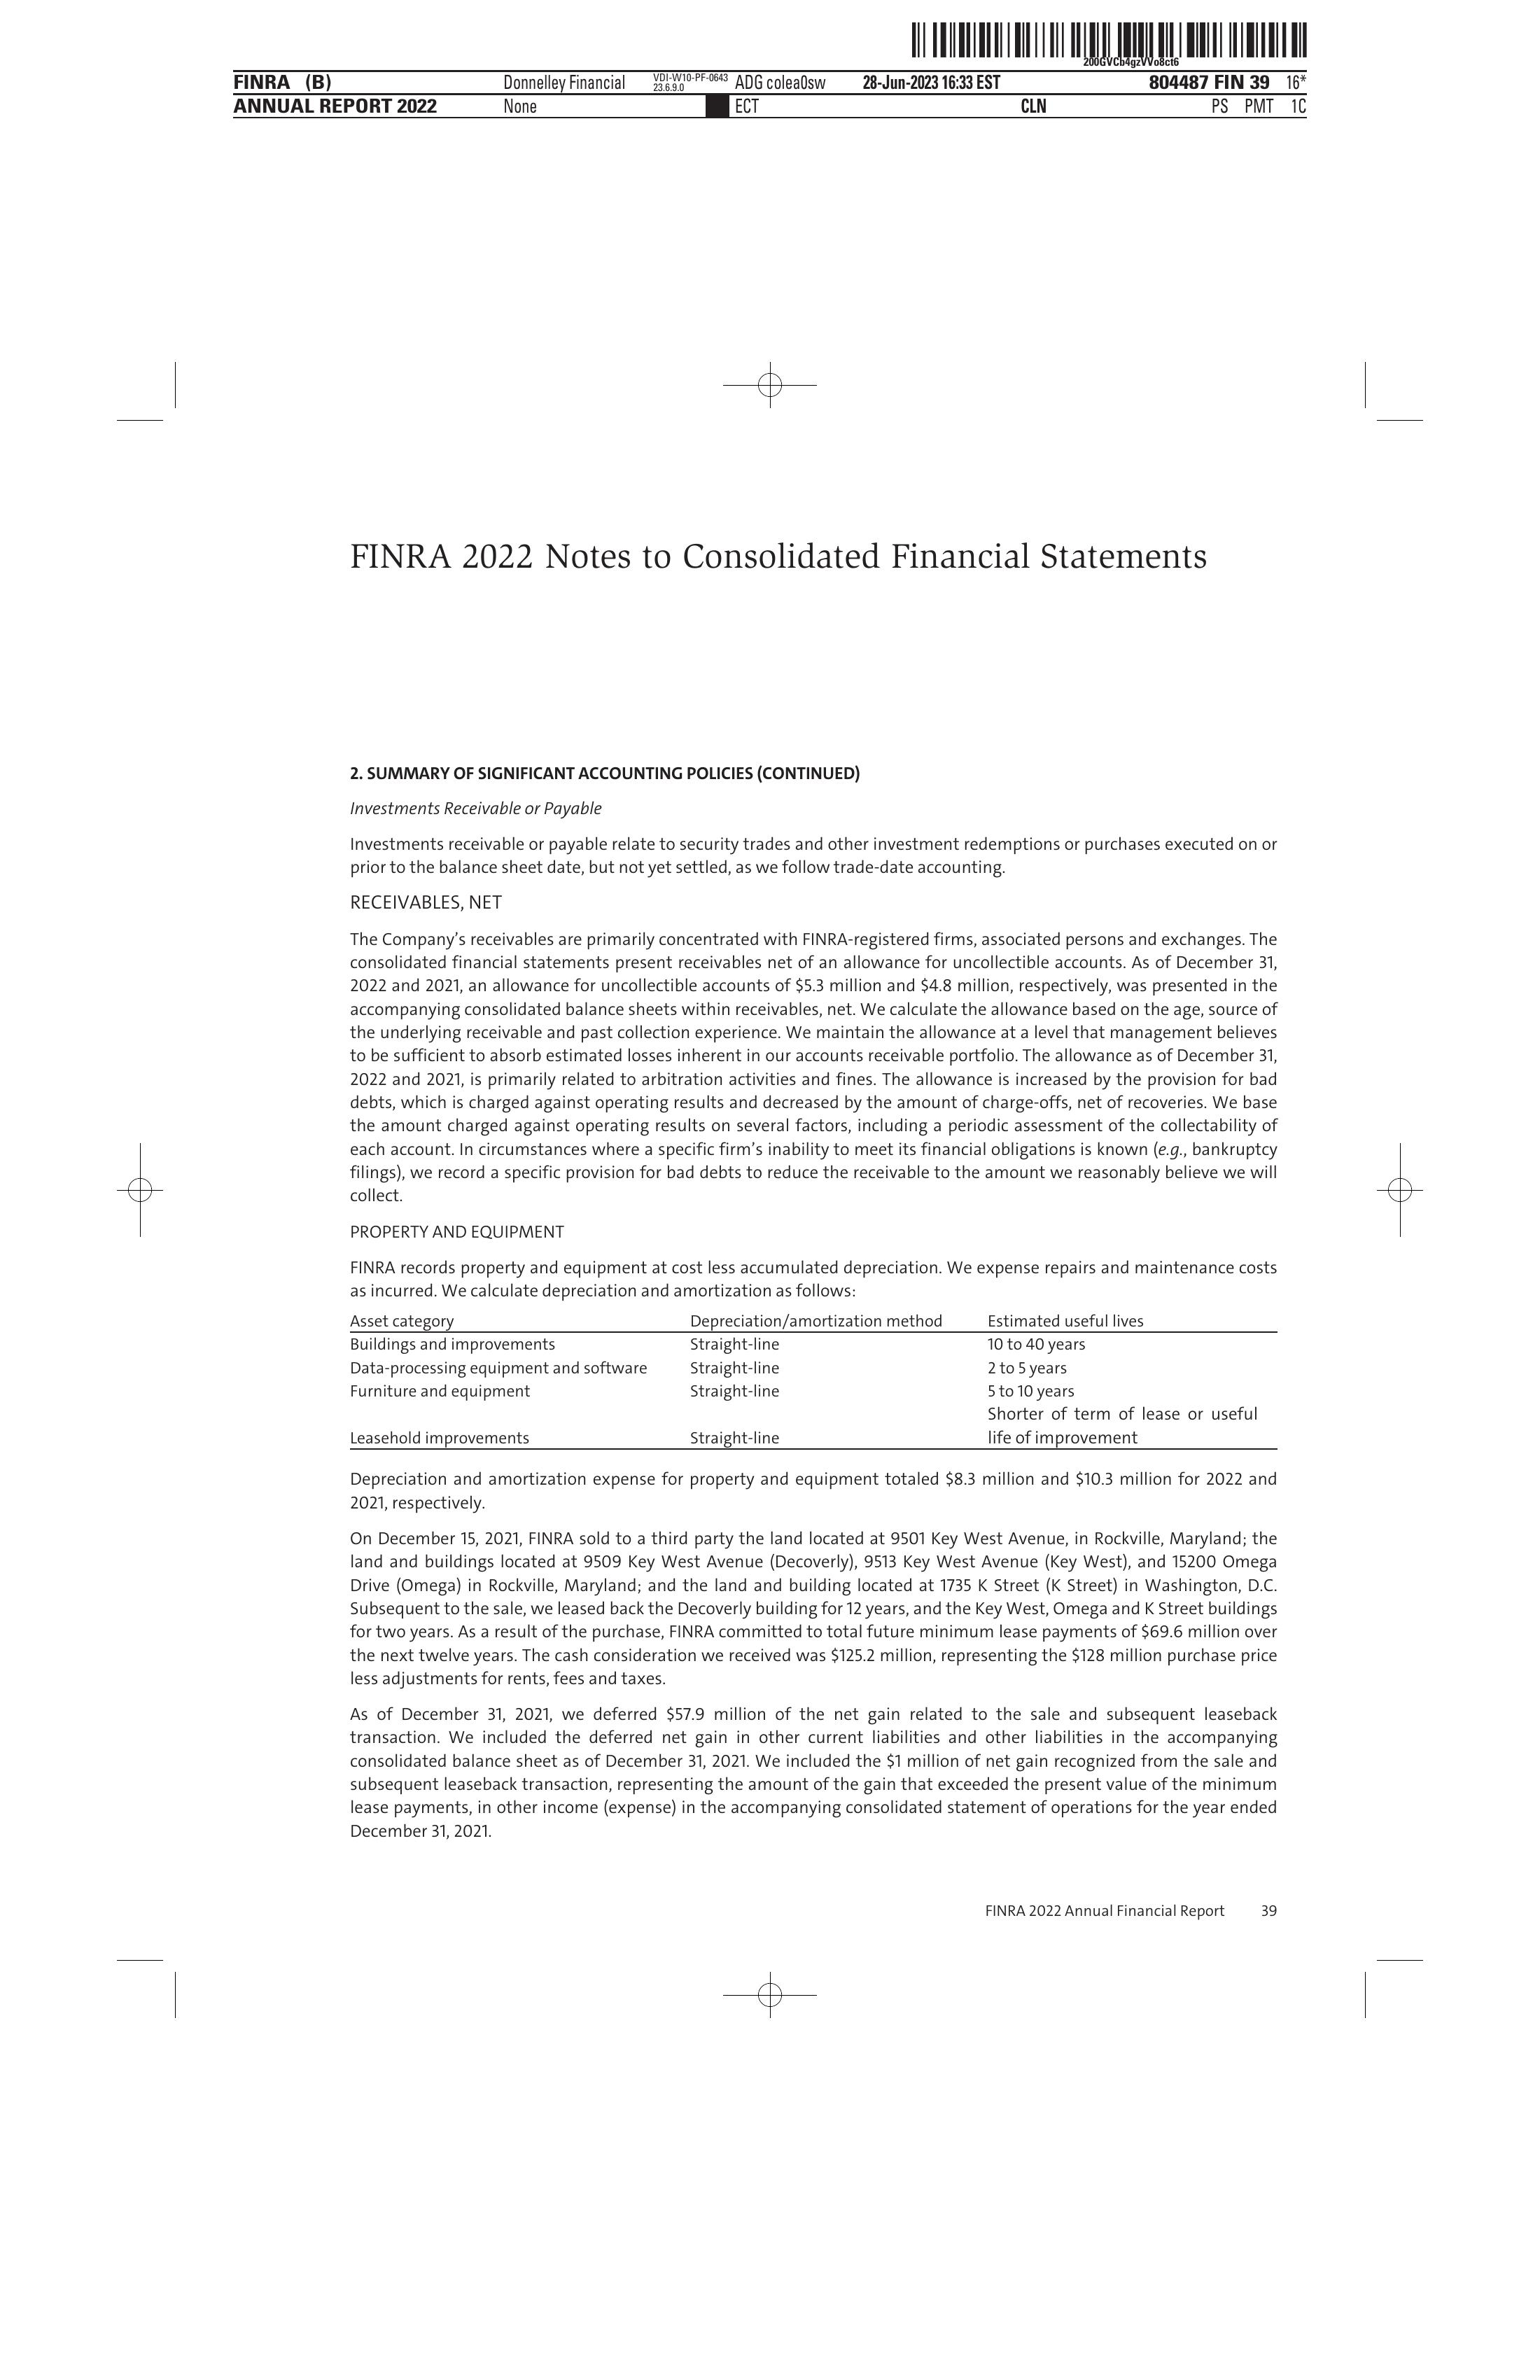

In [52]:
response = paper_pdfs.query.near_vector(
    # Specify the query vectors for each target vector
    near_vector=query_vectors,
    limit=2,
    target_vector=patch_vector_names
)

for o in response.objects:

  for prop in o.properties:
    if not prop.startswith("patch_"):
      print(f"{prop}: {o.properties[prop]}")
  fileName, pageNumber, image_path = o.properties["fileName"], o.properties["pageNumber"], o.properties["image_path"]
  print(f"Filename: {fileName} on page {pageNumber}.")
  display(Image.open(f"{image_path}"))